In [1]:
#####################################################################################
## HW3: Question 3
## Author: Sai Lone
## Created: 11/29
## Edited:  
#####################################################################################

In [2]:
rm(list = ls())

# set working director
setwd("/Users/sailone/Desktop/fall19/EAS506/HW4")

In [45]:
# install.packages("randomForest")
# install.packages("gbm")

also installing the dependency ‘gridExtra’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


(10 points) Apply bagging, boosting, and random forests to a data set of your
choice (not one used in the committee machines labs). Fit the models on a
training set, and evaluate them on a test set. How accurate are these results
compared to more simplistic (non-ensemble) methods (e.g., logistic regression,
kNN, etc)? What are some advantages (and disadvantages) do committee
machines have related to the data set that you selected?

In [3]:
library("rpart")
library(MASS)
library(randomForest)
library(gbm)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Loaded gbm 2.1.5


In [4]:
wine = read.csv('wine.data',header = FALSE) # will use the wine dataset

In [5]:
dim(wine)
head(wine)

#################################################
# Clean the wine data
#################################################

# Let's change column
colnames(wine) <- c("Cultivar", 
                        "Alcohol",
                        "MalicAcid",
                        "Ash",
                        "AlcAsh",
                        "Mg",
                        "Phenols",
                        "Flavanoids",
                        "Nonflavanoid_Phenols",
                        "Proanthocyanins",
                        "Color",
                        "Hue",
                        "OD",
                        "Proline")
names(wine)

[1] 178  14

V1 V2    V3   V4   V5   V6  V7   V8   V9   V10  V11  V12  V13  V14 
1 1  14.23 1.71 2.43 15.6 127 2.80 3.06 0.28 2.29 5.64 1.04 3.92 1065
2 1  13.20 1.78 2.14 11.2 100 2.65 2.76 0.26 1.28 4.38 1.05 3.40 1050
3 1  13.16 2.36 2.67 18.6 101 2.80 3.24 0.30 2.81 5.68 1.03 3.17 1185
4 1  14.37 1.95 2.50 16.8 113 3.85 3.49 0.24 2.18 7.80 0.86 3.45 1480
5 1  13.24 2.59 2.87 21.0 118 2.80 2.69 0.39 1.82 4.32 1.04 2.93  735
6 1  14.20 1.76 2.45 15.2 112 3.27 3.39 0.34 1.97 6.75 1.05 2.85 1450

[1] "Cultivar"             "Alcohol"              "MalicAcid"           
 [4] "Ash"                  "AlcAsh"               "Mg"                  
 [7] "Phenols"              "Flavanoids"           "Nonflavanoid_Phenols"
[10] "Proanthocyanins"      "Color"                "Hue"                 
[13] "OD"                   "Proline"

In [6]:
# reduce the dataset into a binary class dataset with only the
# wine data for cultivar  Barolo as 1 and Barbera and Grignolino 0
barolo <- ifelse(wine$Cultivar == '1', yes = 'YES', no = 'NO')
my_wine <- data.frame(wine[,-1], barolo)

In [7]:
head(my_wine)

Alcohol MalicAcid Ash  AlcAsh Mg  Phenols Flavanoids Nonflavanoid_Phenols
1 14.23   1.71      2.43 15.6   127 2.80    3.06       0.28                
2 13.20   1.78      2.14 11.2   100 2.65    2.76       0.26                
3 13.16   2.36      2.67 18.6   101 2.80    3.24       0.30                
4 14.37   1.95      2.50 16.8   113 3.85    3.49       0.24                
5 13.24   2.59      2.87 21.0   118 2.80    2.69       0.39                
6 14.20   1.76      2.45 15.2   112 3.27    3.39       0.34                
  Proanthocyanins Color Hue  OD   Proline barolo
1 2.29            5.64  1.04 3.92 1065    YES   
2 1.28            4.38  1.05 3.40 1050    YES   
3 2.81            5.68  1.03 3.17 1185    YES   
4 2.18            7.80  0.86 3.45 1480    YES   
5 1.82            4.32  1.04 2.93  735    YES   
6 1.97            6.75  1.05 2.85 1450    YES

In [8]:
# set the seen, and put aside a test set
set.seed(1)
test_indis <- sample(1:nrow(my_wine), .20*nrow(my_wine))
test <- my_wine[test_indis,]
training <- my_wine[-test_indis,]
y_true_test <- as.numeric(test$barolo)-1 # 1 as Barolo and 0 as not Barolo
y_true_train <- as.numeric(training$barolo)-1

In [9]:
#################################################
# Grow a single tree
#################################################
model.control <- rpart.control(minsplit = 5, xval = 10, cp = 0)
fit <- rpart(barolo~., data = training, method = "class", control = model.control)

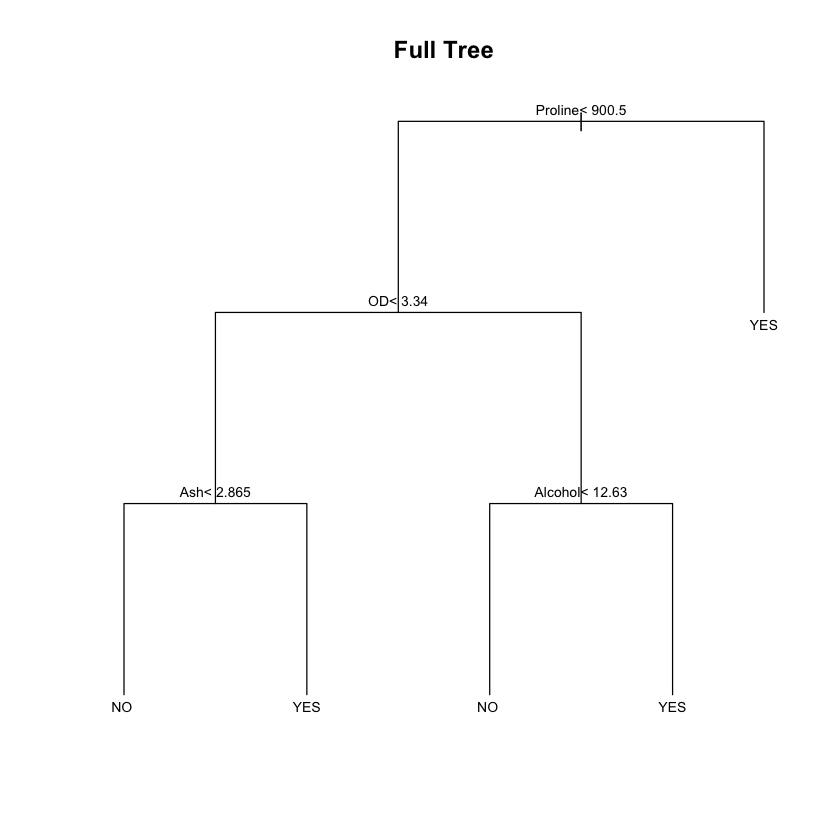

In [10]:
plot(fit, uniform = T, compress = T, main = "Full Tree")
text(fit, cex = .7)

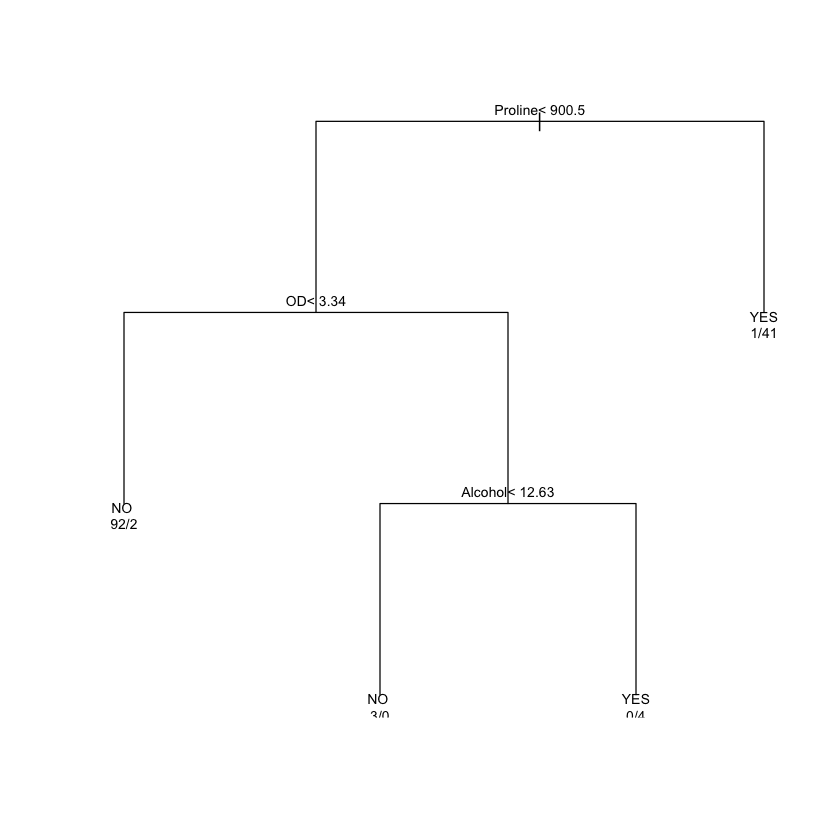

In [11]:
# lets pruned the tree
# prune the tree back
min_cp = which.min(fit$cptable[,4])

pruned_fit <- prune(fit, cp = fit$cptable[min_cp, 1])
plot(pruned_fit, uniform = T, compress = T)
text(pruned_fit, use.n = TRUE, cex = .7)

# Compute test error for a single tree
my_pred <- predict(pruned_fit, newdata = test, type = "class")
y_hat <- as.numeric(my_pred)-1

In [13]:
# Compute the error rate
misclass_tree <- sum(abs(y_true_test - y_hat))/length(y_hat)
misclass_tree #0.085 - not bad but let's see if you can do better

[1] 0.08571429

In [22]:
###############################################
# Random Forest 
###############################################
rf.fit <- randomForest(barolo~., data = training, n.tree = 200)

MeanDecreaseGini
Alcohol               7.7111006      
MalicAcid             1.1602131      
Ash                   0.9664902      
AlcAsh                2.5626688      
Mg                    2.5964527      
Phenols               5.4986398      
Flavanoids           11.5024428      
Nonflavanoid_Phenols  1.8149862      
Proanthocyanins       1.4402375      
Color                 2.7835178      
Hue                   1.5517198      
OD                    4.3202324      
Proline              18.8090046

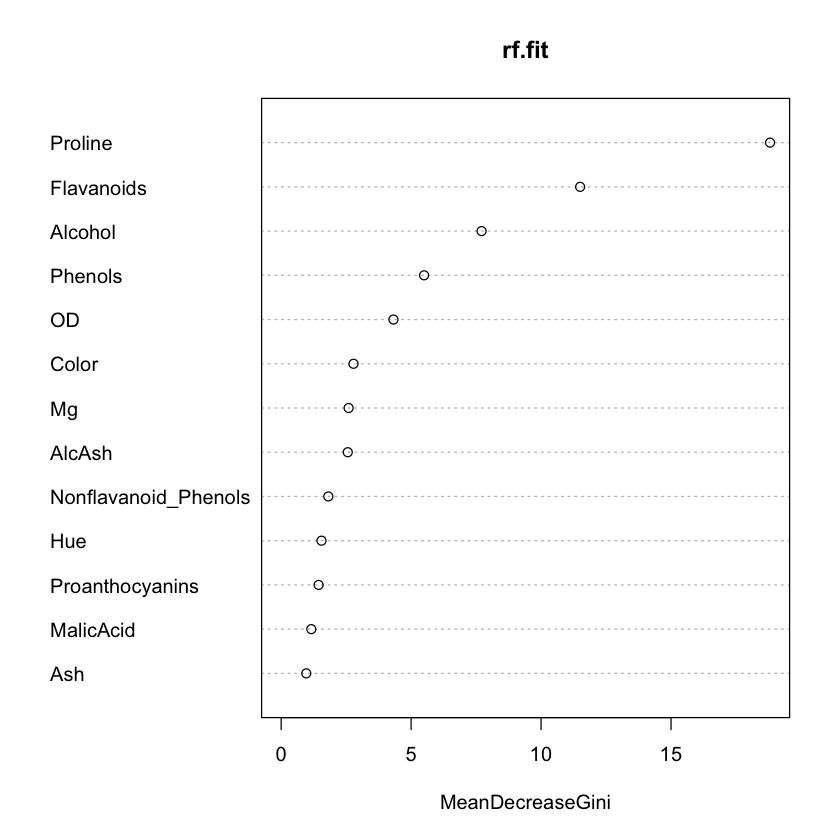

In [23]:
varImpPlot(rf.fit)
importance(rf.fit)

In [24]:
y_hat <- predict(rf.fit, newdata = test, type = "response")
y_hat <- as.numeric(y_hat)-1
# Compute the error rate
misclass_bag <- sum(abs(y_true_test- y_hat))/length(y_hat)
misclass_bag # 0.057 better then our pruned tree

[1] 0.05714286

MeanDecreaseGini
Alcohol               0.8785703      
MalicAcid             0.1298847      
Ash                   1.1716379      
AlcAsh                0.4107232      
Mg                    0.6784163      
Phenols               0.2070975      
Flavanoids            3.9660915      
Nonflavanoid_Phenols  0.1179919      
Proanthocyanins       0.2506803      
Color                 0.3871356      
Hue                   0.3445310      
OD                    2.7127036      
Proline              51.1514734

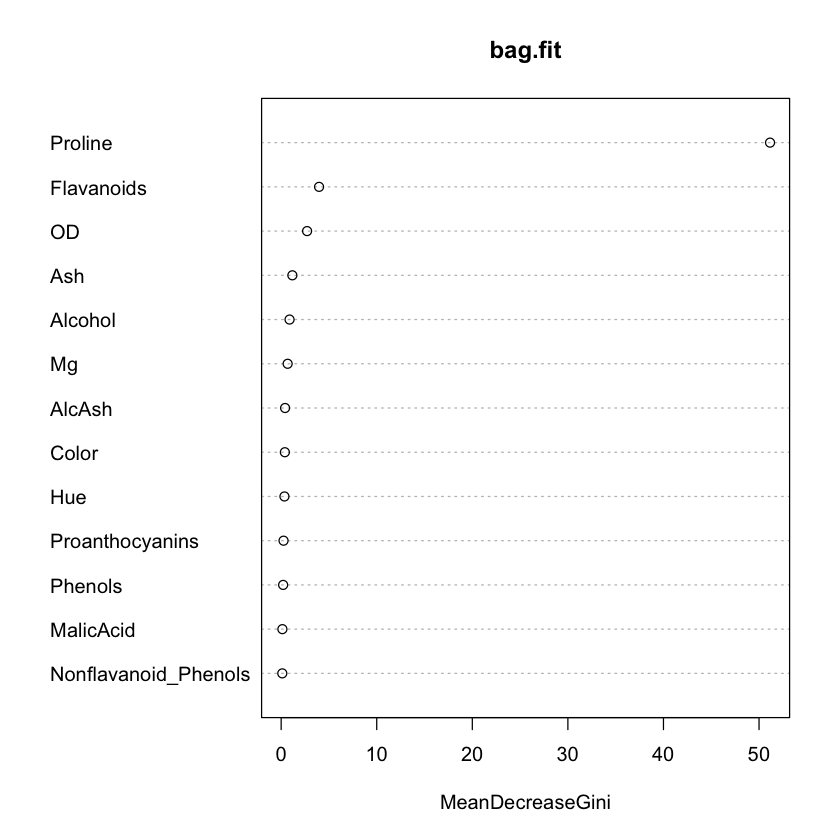

In [25]:
###############################################
# Bagging
###############################################
bag.fit <- randomForest(barolo~., data = training, n.tree = 200, mtry = 13)

varImpPlot(bag.fit)
importance(bag.fit)

In [26]:
y_hat <- predict(bag.fit, newdata = test, type = "response")
y_hat <- as.numeric(y_hat)-1
misclass_bag <- sum(abs(y_true_test- y_hat))/length(y_hat)
misclass_bag # 0.057 - we get the same error rate as our random forest model


[1] 0.05714286

In [27]:
###############################################
# Boosting
###############################################

# We have to recode the data for boosting
boost.train <- training
boost.train$barolo <- as.numeric(training$barolo)-1
boost.test <- test
boost.test$barolo <- as.numeric(test$barolo)-1

var                  rel.inf     
Proline              Proline              62.355670905
Flavanoids           Flavanoids           30.173419973
OD                   OD                    1.831510037
Alcohol              Alcohol               1.495256962
Mg                   Mg                    1.289253627
Ash                  Ash                   0.766002513
Hue                  Hue                   0.687989021
Proanthocyanins      Proanthocyanins       0.640461415
Color                Color                 0.269913223
AlcAsh               AlcAsh                0.254099537
MalicAcid            MalicAcid             0.147822356
Phenols              Phenols               0.086207133
Nonflavanoid_Phenols Nonflavanoid_Phenols  0.002393297

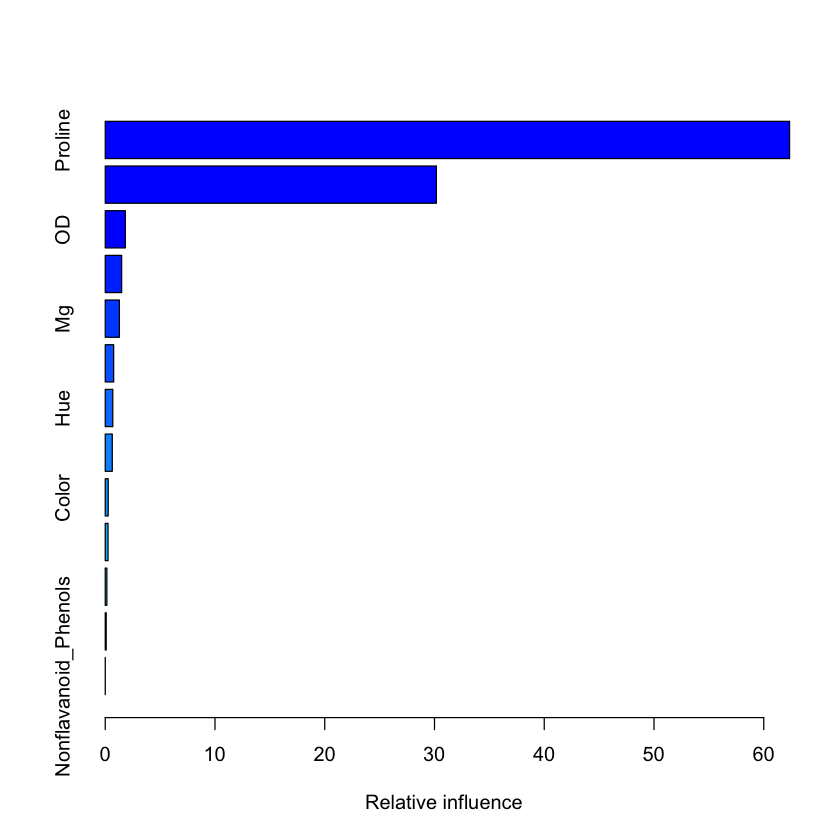

In [28]:
boost.fit <- gbm(barolo~., data = boost.train, n.trees = 200, shrinkage = .1, interaction.depth = 3, distribution = "adaboost")

summary(boost.fit)

In [29]:
# Look at the error for shrinkage = .1
y_hat <- predict(boost.fit, newdata = boost.test, n.trees = 200, type = "response")
misclass_boost.1 <- sum(abs(y_hat - y_true))/ length(y_true)
misclass_boost.1 # 0.0571632175965694 - vary small difference but gives better results


ERROR: Error in eval(expr, envir, enclos): object 'y_true' not found


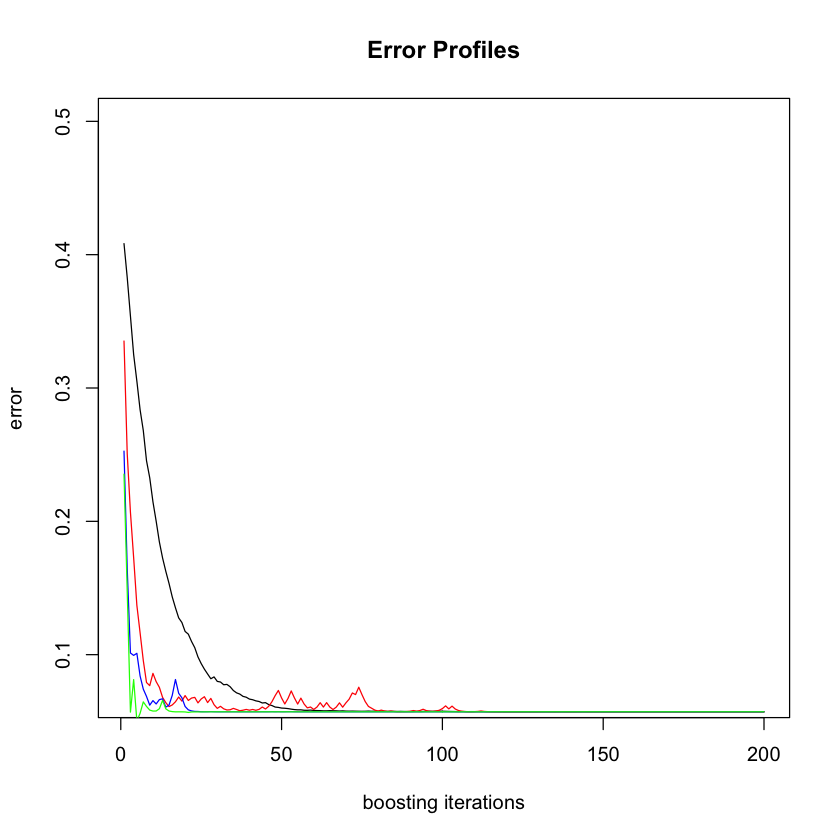

In [32]:
# Lets increase shrinkage
shrink <- c(.1, .4, .6, .8)
max_iter <- 200
store_error <- c()
for (i in 1:length(shrink)){
	boost.fit <- gbm(barolo~., data = boost.train, n.trees = max_iter, shrinkage = shrink[i], interaction.depth = 3, distribution = "adaboost")
	temp <- c()
	for (j in 1:max_iter){
		y_hat <- predict(boost.fit, newdat = boost.test, n.trees = j, type = "response")
		misclass_boost <- sum(abs(y_true_test - y_hat))/length(y_hat)
		temp <- c(temp, misclass_boost)
	}
	store_error <- cbind(store_error, temp) # max_iter x length(shrink)
}

colnames(store_error) <- paste("shrinkage", shrink, sep = ":")

# Plot the results
plot(store_error[,1], type = "l", main = "Error Profiles", ylab = "error", xlab = "boosting iterations", ylim = c(.07, .5))
lines(store_error[,2], col = "red")
lines(store_error[,3], col = "blue")
lines(store_error[,4], col = "green")

In [33]:
store_error[200,]
# best error rate we can do with shrinkage 0.8 and 200 iteration
min(store_error[200,])


shrinkage:0.1 shrinkage:0.4 shrinkage:0.6 shrinkage:0.8 
   0.05714602    0.05714287    0.05714286    0.05714286

[1] 0.05714286

In [34]:
###############################################
# Lets preform the same dataset on non-ensemble methods
###############################################

# lets set the seed and get the fit for KNN
set.seed(123)
train <- sample(1:nrow(my_wine), .80*nrow(my_wine))
wine_train <- my_wine[train,]
wine_test <- my_wine[-train,]

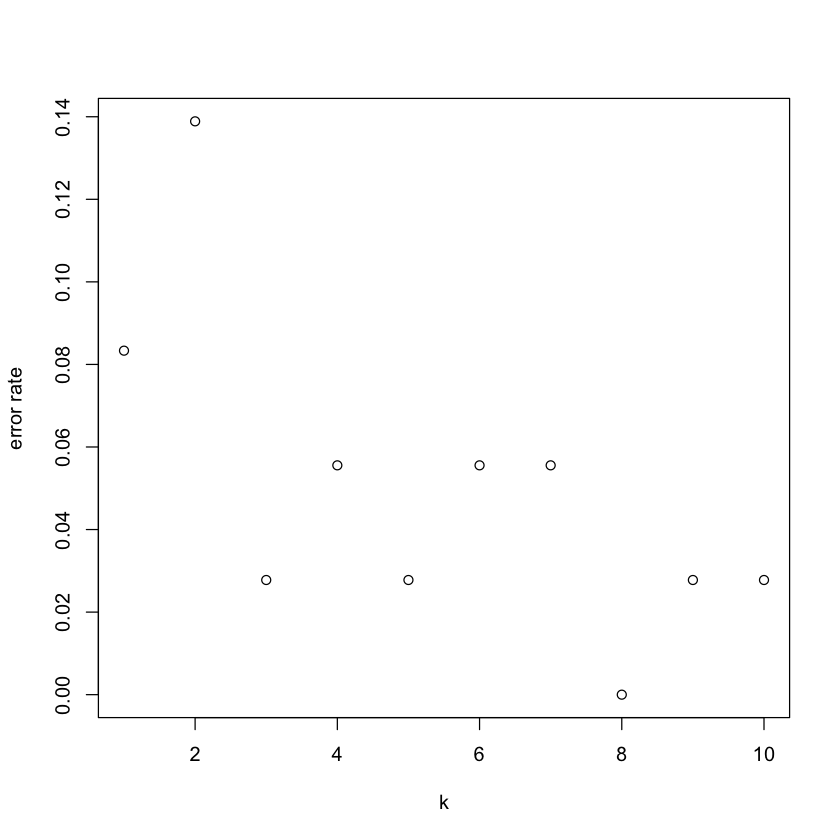

In [40]:
require(class) # load class lib to use the knn function

# Calculate the error rates for k = 1 to 10
error_on_k <- c()
for (i in 1:10){
	knn.fit <- knn(wine_train[1:13], wine_test[1:13], wine_train$barolo, k=i)
	error_on_k[i] = mean(knn.fit != wine_test$barolo)
}

plot(error_on_k, xlab = "k" , ylab = "error rate")

In [37]:
min(error_on_k) # best error rate using KNN

[1] 0.02777778